<a href="https://colab.research.google.com/github/hasannader/Birthday-gift/blob/main/GANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install pillow-heif

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 62.5 MB/s eta 0:00:00


In [3]:
from google.colab import drive
import shutil
import zipfile
import os
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import glob
import pillow_heif
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
from google.colab import drive
import shutil

# Define the path to your file in Google Drive
file_path = '/content/drive/MyDrive/drive-download-20250912T092540Z-1-001.zip'

# Define the destination path in Colab's local storage
destination_path = '/content/drive-download-20250912T092540Z-1-001.zip'

# Copy the file to Colab's local storage
shutil.copy(file_path, destination_path)

print("File copied to Colab's local storage!")

File copied to Colab's local storage!


In [6]:
import zipfile
import os

# Path to your zip file
zip_path = "/content/drive-download-20250912T092540Z-1-001.zip"

# Destination folder
dest_folder = "/content/data"

# Create destination folder if it doesn't exist
os.makedirs(dest_folder, exist_ok=True)

# Extract zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(dest_folder)

print(f"Unzipped to: {dest_folder}")

Unzipped to: /content/data


In [7]:
# import os
from PIL import Image
import pillow_heif  # plugin to read HEIC

# Input and output folders
input_dir = "/content/data"
output_dir = "/content/jpg_data"

# Create output folder if not exists
os.makedirs(output_dir, exist_ok=True)

# Loop through files
for filename in os.listdir(input_dir):
    file_path = os.path.join(input_dir, filename)

    # Skip non-files
    if not os.path.isfile(file_path):
        continue

    # Handle HEIC
    if filename.lower().endswith(".heic"):
        heif_file = pillow_heif.read_heif(file_path)
        img = Image.frombytes(
            heif_file.mode,
            heif_file.size,
            heif_file.data,
            "raw"
        )
        new_name = os.path.splitext(filename)[0] + ".jpg"
        img.save(os.path.join(output_dir, new_name), "JPEG")

    # Handle JPG
    elif filename.lower().endswith(".jpg") or filename.lower().endswith(".jpeg"):
        new_name = os.path.splitext(filename)[0] + ".jpg"
        img = Image.open(file_path).convert("RGB")
        img.save(os.path.join(output_dir, new_name), "JPEG")

print("✅ Conversion finished! All images are saved as .jpg in:", output_dir)

✅ Conversion finished! All images are saved as .jpg in: /content/jpg_data


In [8]:
# Hyperparameters
latent_dim = 100
img_size = 64
batch_size = 64
num_epochs = 50
lr = 0.0002
beta1 = 0.5
device = "cuda" if torch.cuda.is_available() else "cpu"

In [9]:
# ============================
# GAN Model Classes
# ============================

class Generator(nn.Module):
    def __init__(self, latent_dim, img_size):
        super(Generator, self).__init__()
        self.init_size = img_size // 4
        self.l1 = nn.Sequential(nn.Linear(latent_dim, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 3, 3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

class Discriminator(nn.Module):
    def __init__(self, img_size):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, bn=True):
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.model = nn.Sequential(
            *discriminator_block(3, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        ds_size = img_size // 2 ** 4
        self.adv_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, 1), nn.Sigmoid())

    def forward(self, img):
        out = self.model(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)
        return validity

In [10]:
# Initialize generator and discriminator
generator = Generator(latent_dim=latent_dim, img_size=img_size).to(device)
discriminator = Discriminator(img_size=img_size).to(device)

# Loss function and optimizers
criterion = nn.BCELoss()
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

# --------------------
# Data Loader
# --------------------
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

class MyImageDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.transform = transform
        self.image_paths = glob.glob(folder_path + "/*.jpg")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img

dataset = MyImageDataset(folder_path="jpg_data", transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
print(f"Total images: {len(dataset)}")


Total images: 38


In [11]:
# ============================
# 8. Training Loop
# ============================
for epoch in range(num_epochs):
    for i, imgs in enumerate(dataloader):
        imgs = imgs.to(device)
        batch_size_curr = imgs.size(0)
        valid = torch.ones(batch_size_curr, 1, device=device)
        fake = torch.zeros(batch_size_curr, 1, device=device)

        # Train Generator
        optimizer_G.zero_grad()
        z = torch.randn(batch_size_curr, latent_dim, device=device)
        gen_imgs = generator(z)
        g_loss = criterion(discriminator(gen_imgs), valid)
        g_loss.backward()
        optimizer_G.step()

        # Train Discriminator
        optimizer_D.zero_grad()
        real_loss = criterion(discriminator(imgs), valid)
        fake_loss = criterion(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

    print(f"[Epoch {epoch+1}/{num_epochs}] D loss: {d_loss.item():.4f} | G loss: {g_loss.item():.4f}")

    if (epoch + 1) % 10 == 0:
        save_image(gen_imgs.data[:25], f"generated_{epoch+1}.png", nrow=5, normalize=True)

[Epoch 1/50] D loss: 0.6928 | G loss: 0.7029
[Epoch 2/50] D loss: 0.6932 | G loss: 0.7020
[Epoch 3/50] D loss: 0.6924 | G loss: 0.7013
[Epoch 4/50] D loss: 0.6913 | G loss: 0.7004
[Epoch 5/50] D loss: 0.6919 | G loss: 0.6993
[Epoch 6/50] D loss: 0.6908 | G loss: 0.6981
[Epoch 7/50] D loss: 0.6901 | G loss: 0.6978
[Epoch 8/50] D loss: 0.6902 | G loss: 0.6975
[Epoch 9/50] D loss: 0.6894 | G loss: 0.6969
[Epoch 10/50] D loss: 0.6880 | G loss: 0.6968
[Epoch 11/50] D loss: 0.6875 | G loss: 0.6955
[Epoch 12/50] D loss: 0.6885 | G loss: 0.6950
[Epoch 13/50] D loss: 0.6864 | G loss: 0.6952
[Epoch 14/50] D loss: 0.6857 | G loss: 0.6953
[Epoch 15/50] D loss: 0.6815 | G loss: 0.6947
[Epoch 16/50] D loss: 0.6824 | G loss: 0.6931
[Epoch 17/50] D loss: 0.6812 | G loss: 0.6921
[Epoch 18/50] D loss: 0.6795 | G loss: 0.6927
[Epoch 19/50] D loss: 0.6800 | G loss: 0.6881
[Epoch 20/50] D loss: 0.6747 | G loss: 0.6859
[Epoch 21/50] D loss: 0.6776 | G loss: 0.6804
[Epoch 22/50] D loss: 0.6793 | G loss: 0.67

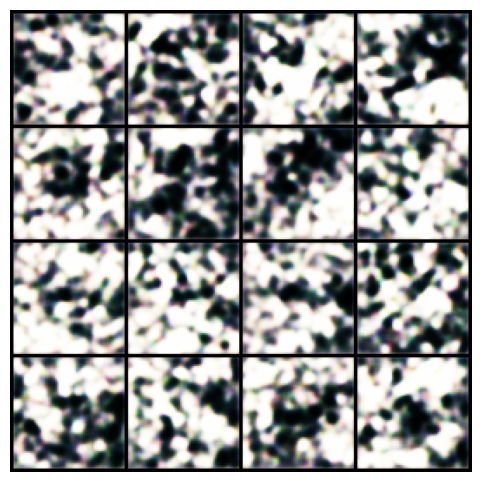

In [12]:
# ============================
# 9. Generate Final Images from Random Noise
# ============================
generator.eval()
with torch.no_grad():
    z = torch.randn(16, latent_dim, device=device)
    gen_imgs = generator(z).cpu()
    grid = make_grid(gen_imgs, nrow=4, normalize=True)

plt.figure(figsize=(6,6))
plt.imshow(grid.permute(1, 2, 0).detach().numpy())
plt.axis("off")
plt.show()